In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import sys
import pandas as pd
import itertools
import util
import os, re

/home/shush/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [17]:
res_summary_path = 'tss_and_background_shuffle_results.csv'
res_summary = pd.read_csv(res_summary_path)
labeled = pd.read_csv('labelled.csv')
result_base_dir = '/shared/shush/results/CREME'
dfs = []

res_paths = glob.glob(f'{result_base_dir}/interrogate_cres/*.pickle')
for res_path in res_paths:
    res = util.dict_load(res_path)
    seq_i = res_path.split('/')[-1].split('.')[0]
    if int(seq_i) in res_summary['path'].values:
        res_label = labeled[labeled['TSS_index']==int(seq_i)]['context'].values[0].split()[0]
        shuffle_res = res['shuffle_each_tile']
        gia_neg_control = res['shuffle_non_tss']
        gia_res = []
        tile_coords = []
        for l in list(res.keys()):
            try:
                int(l)
                tile_coords.append(l)
                gia_res.append(res[l])
            except:
                pass
        gia_res = np.array(gia_res)

        gia = gia_res.mean(axis=-1) 
        gia_neg_control = gia_neg_control[:, 448].mean()
        shuffle = shuffle_res.mean(axis=-1) 
        wt = res['wt_pred'][0,448]
        df = pd.DataFrame(np.array([gia, shuffle]).T, columns=['gia', 'shuffle'])
        df['tile coordinate'] = tile_coords
        df['neg_control_gia'] = gia_neg_control
        df['wt'] = wt
        df['background class'] = res_label
        df['path'] = seq_i
        tss_label = [False for _ in range(len(gia))]
        tss_label[19] = True
        df['tss'] = tss_label
        
        dfs.append(df)
dfs = pd.concat(dfs)

In [18]:
context_dict = {'enhancers': 'enhancing', 
                'repressors': 'repressing', 
                'neutral': 'neutral'}
dfs['Tile addition effect size'] = (dfs['gia'] - dfs['neg_control_gia'] )/ dfs['wt']
dfs['Tile shuffle effect size'] = (dfs['wt']-dfs['shuffle']) / dfs['wt']
dfs['context'] =  [context_dict[b] for b in dfs['background class']]
non_tss = dfs[~dfs['tss']]

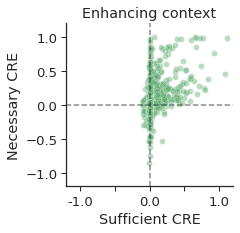

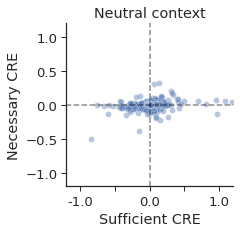

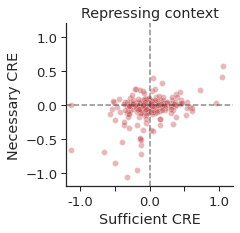

In [19]:
sns.set(font_scale = 1.2)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
colors = {'enhancing':'g',
          'neutral': 'b', 
          'repressing': 'r'}

non_tss = dfs[~dfs['tss']] 
for i, (c, df) in enumerate(non_tss.groupby('context')):
    fig = plt.figure(figsize=[3,3])
    ax=sns.scatterplot(data=df, x='Tile addition effect size',
                   y='Tile shuffle effect size', alpha=.4, c=colors[c])
    if c == 'enhancing':
        ax.set_title('Enhancing context')
    if c == 'neutral':
        ax.set_title('Neutral context')
    if c == 'repressing':
        ax.set_title('Repressing context')
    ax.set_ylabel('Necessary CRE')
    ax.set_xlabel('Sufficient CRE')
#     if i !=1:
#         ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.plot([-2,2],[0,0],'--k', alpha=0.5)
    plt.plot([0,0],[-2,2],'--k', alpha=0.5)
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    plt.xticks([-1,-.5,0,.5,1],['-1.0', '', '0.0', '', '1.0'])
    plt.show()
#     fig.savefig(str(i)+'_essential_vs_sufficient.pdf', format='pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()



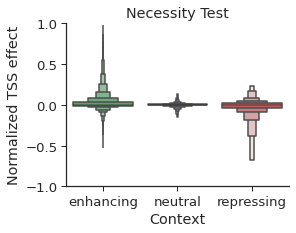

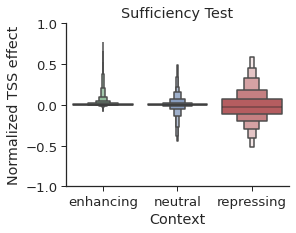

In [20]:
for i,y in enumerate(['Tile shuffle effect size', 'Tile addition effect size']):
    fig = plt.figure(figsize=[4,3])
    elements = [ 'enhancing', 'neutral', 'repressing']
    state_plot_params = {
        'data': non_tss,
        'x': 'context',
        'y': y,
        'order': elements,
        'palette': ['g', 'b', 'r'],
        'showfliers': False
    }
    ax = sns.boxenplot(**state_plot_params)
    if 'shuffle' in y:
        plt.title('Necessity Test')
    else:
        plt.title('Sufficiency Test')
    plt.ylabel('Normalized TSS effect')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(-1,1)
    plt.yticks([-1, -.5, 0, .5, 1])
    plt.xlabel('Context')
#     fig.savefig(str(i)+'_CRE.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [21]:
for k, v in {'shuffle': 'Tile shuffle effect size', 'gia': 'Tile addition effect size'}.items():
    binned_cres = pd.cut(non_tss[v],
                   bins=[0.3, 0.5, 1],labels=['weak', 'strong'])

    binned_cres_neg = pd.cut(non_tss[v],
                   bins=[-4, -0.5, -0.3],labels=['strong', 'weak'])
    enh_key = 'enhancer CREs'
    rep_key = 'repressor CREs'
    non_tss[enh_key] = binned_cres
    non_tss[rep_key] = binned_cres_neg

    cre_class = []
    for i, row in non_tss.iterrows():
        if isinstance(row[enh_key], str):
            cre_class.append('enhancing \n '+ row[enh_key])
        elif isinstance(row[rep_key], str):
            cre_class.append('repressing \n ' + row[rep_key])
        else:
            cre_class.append('Other')
    non_tss[f'CRE type {k}'] = cre_class


non_tss['distance to TSS (Kb)'] = [(int(i) - 196608 + 2500) // 1000 for i in non_tss['tile coordinate'].values ]

/tmp/ipykernel_3868612/1451758868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_tss[enh_key] = binned_cres
/tmp/ipykernel_3868612/1451758868.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_tss[rep_key] = binned_cres_neg
/tmp/ipykernel_3868612/1451758868.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [22]:
non_tss.to_csv('non_tss_cres.csv', index=None)

In [23]:
enhancer_df = non_tss[[True if 'enh' in c else False for c in non_tss['CRE type gia']]]
repressor_df = non_tss[[True if 'repr' in c else False for c in non_tss['CRE type gia']]]

In [24]:
enhancer_df = enhancer_df[enhancer_df['context']=='enhancing']
repressor_df = repressor_df[repressor_df['context']=='repressing']

In [25]:
enhancer_df

,gia,shuffle,tile coordinate,neg_control_gia,wt,background class,path,tss,Tile addition effect size,Tile shuffle effect size,context,enhancer CREs,repressor CREs,CRE type shuffle,CRE type gia,distance to TSS (Kb)
20,96.759501,184.539056,199108,0.116199,230.590271,enhancers,53444,False,0.419113,0.199710,enhancing,weak,NaN,Other,enhancing \n weak,5
22,121.253842,187.600429,209108,0.116199,230.590271,enhancers,53444,False,0.525337,0.186434,enhancing,strong,NaN,Other,enhancing \n strong,15
20,66.006994,32.958460,199108,2.382307,200.130829,enhancers,114474,False,0.317915,0.835315,enhancing,weak,NaN,enhancing \n strong,enhancing \n weak,5
20,77.829280,175.213484,199108,13.979852,192.761536,enhancers,111945,False,0.331235,0.091035,enhancing,weak,NaN,Other,enhancing \n weak,5
21,82.888750,165.381474,204108,13.979852,192.761536,enhancers,111945,False,0.357483,0.142041,enhancing,weak,NaN,Other,enhancing \n weak,10
20,37.576860,53.028714,199108,0.116360,101.832787,enhancers,35149,False,0.367863,0.479257,enhancing,weak,NaN,enhancing \n weak,enhancing \n weak,5
20,147.072504,265.554916,199108,2.405961,358.681763,enhancers,55787,False,0.403328,0.259636,enhancing,weak,NaN,Other,enhancing \n weak,5
24,136.525606,276.781439,219108,2.405961,358.681763,enhancers,55787,False,0.373924,0.228337,enhancing,weak,NaN,Other,enhancing \n weak,25
17,82.149136,81.067170,184108,5.133539,133.110153,enhancers,48514,False,0.578585,0.390977,enhancing,strong,NaN,enhancing \n weak,enhancing \n strong,-10
18,147.856441,104.459423,189108,5.902728,168.588043,enhancers,96971,False,0.842015,0.380387,enhancing,strong,NaN,enhancing \n weak,enhancing \n strong,-5


('enhancing', 'neutral') 5.023965364140374e-39
('enhancing', 'repressing') 4.832204689855025e-98
('neutral', 'repressing') 1.9603013865553501e-50


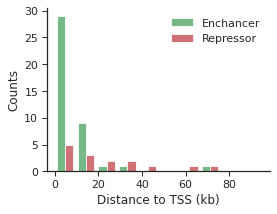

In [26]:

sns.set(font_scale = 1.)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, ax = plt.subplots(1, 1, figsize=[4,3])

N, bins, patches = ax.hist([enhancer_df['distance to TSS (Kb)'].values, repressor_df['distance to TSS (Kb)'].values], bins=10, range=(0,95), alpha=0.8)
for patch in patches[0]:
    patch.set_facecolor('g')
for patch in patches[1]:
    patch.set_facecolor('r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
pvals, pairs = util.get_pvals(elements, state_plot_params['data'], 
                              state_plot_params['x'], 
                              state_plot_params['y'], 'kstest')

for pval, pair in zip(pvals, pairs):
    print(pair, pval)

plt.xlabel('Distance to TSS (kb)')
plt.ylabel('Counts')

plt.legend(['Enchancer', 'Repressor'], frameon=False)
# fig.savefig('observed_distance_to_TSS.pdf', format='pdf', dpi=300, bbox_inches='tight')



In [27]:
enhancer_df.shape

(59, 16)

In [28]:
repressor_df.shape

(26, 16)

In [29]:
tss_df = pd.read_csv(f'{result_base_dir}/TSS.csv')

cre_set = pd.read_csv('non_tss_cres.csv')

cre_set = cre_set[(cre_set['CRE type gia'] != 'Other')]

In [30]:
cre_set

,gia,shuffle,tile coordinate,neg_control_gia,wt,background class,path,tss,Tile addition effect size,Tile shuffle effect size,context,enhancer CREs,repressor CREs,CRE type shuffle,CRE type gia,distance to TSS (Kb)
175,96.759501,184.539056,199108,0.116199,230.590270,enhancers,53444,False,0.419113,0.199710,enhancing,weak,NaN,Other,enhancing \n weak,5
177,121.253842,187.600429,209108,0.116199,230.590270,enhancers,53444,False,0.525337,0.186434,enhancing,strong,NaN,Other,enhancing \n strong,15
253,66.006994,32.958460,199108,2.382307,200.130830,enhancers,114474,False,0.317915,0.835315,enhancing,weak,NaN,enhancing \n strong,enhancing \n weak,5
682,77.829280,175.213484,199108,13.979852,192.761540,enhancers,111945,False,0.331235,0.091035,enhancing,weak,NaN,Other,enhancing \n weak,5
683,82.888750,165.381474,204108,13.979852,192.761540,enhancers,111945,False,0.357483,0.142041,enhancing,weak,NaN,Other,enhancing \n weak,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7439,21.476652,31.543175,249108,37.931191,31.135000,neutral,69614,False,-0.528490,-0.013110,neutral,NaN,strong,Other,repressing \n strong,55
7446,25.845606,32.612775,284108,37.931191,31.135000,neutral,69614,False,-0.388167,-0.047463,neutral,NaN,weak,Other,repressing \n weak,90
7694,79.876642,145.931444,154108,6.533751,183.582810,enhancers,93751,False,0.399508,0.205092,enhancing,weak,NaN,Other,enhancing \n weak,-40
7704,63.653618,173.910751,209108,6.533751,183.582810,enhancers,93751,False,0.311140,0.052685,enhancing,weak,NaN,Other,enhancing \n weak,15


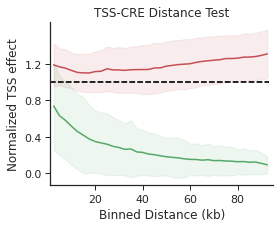

In [31]:
L = 78
midpoint = int(L/2)
sns.set(font_scale = 1.)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, axes = plt.subplots(1, 1, figsize=[4,3])
colors = ['g', 'r']
for b, cre_type_df in enumerate([enhancer_df, repressor_df]):
#     cre_type_df = cre_set[cre_set['background class'] == background_type]

#     for cre_type, cre_type_df in active_cres.groupby('CRE type'):
    gia_scores = np.empty((cre_type_df.shape[0], 78))
    enh_paths = cre_type_df['path'].values
    for i, (_,row) in enumerate(cre_type_df.iterrows()):
        path = f"/shared/shush/results/GIA_CRE_dist/{row['path']}_tile_{row['tile coordinate']}.pickle"
        assert os.path.isfile(path)
        res = util.dict_load(path)
        positions = np.array([k for k in res.keys() if re.search('[0-9]+', k)])
        wt_pred = res['wt_pred'][0, 448]
        neg_control = res['shuffle_non_tss'].mean(axis=0)[448]
        original_pos_pred = res[positions[np.argwhere(positions==str(row['tile coordinate']))[0][0]]].mean()
        gia_scores[i] = [v.mean() / original_pos_pred for k,v in res.items() if k in positions]

    ax = axes#[b]
    #mean = gia_scores.mean(axis=0)
    #std = gia_scores.std(axis=0)
    gia = (gia_scores[:,:midpoint][:,::-1] + gia_scores[:,midpoint:])/2
    mean = np.mean(gia[:,2:], axis=0)
    std = np.std(gia[:,2:], axis=0)
    ax.plot(np.arange(1,len(mean)+1)*2.5,mean, alpha=1, color=colors[b])
    ax.fill_between(np.arange(1,len(mean)+1)*2.5, mean-std, mean+std, alpha=0.1, color=colors[b])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.plot([1,93],[1,1], '--k')
    plt.xlim([1,95])
    plt.yticks([0, 0.4, 0.8, 1.2])
    plt.ylabel('Normalized TSS effect')
    plt.xlabel('Binned Distance (kb)')
# plt.legend(['Enhancer', '', '', 'Repressor'], frameon=False)
plt.title('TSS-CRE Distance Test')
fig.savefig('../distance_dependence.pdf', format='pdf', dpi=300, bbox_inches='tight')
